In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# pd.set_option("display.max_columns", 100)

In [115]:
# gaussian fit for B0_MM gave:  [1411.94167539 5280.92240713   16.11397562]
# Therefore all the datapoints that are more than 3 sigma away from the mean can be considered to be background
sig = 16.11397562
mean = 5280.92240713
min_mass = mean - 3*sig
max_mass = mean + 3*sig
df = pd.read_pickle("total_dataset_filtered.pkl") # dataset filtered of peaking background
df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1) # signal and background should have the same columns
print("Total dataset number of events: ", len(df))
bg = df[(df["B0_MM"] < min_mass) | (df["B0_MM"] > max_mass)] # far ends are mostly background
print("Number of background events: ", len(bg)) # bg - background

signal = pd.read_csv("../data/csv/sig.csv") # as a signal, simulated data is used
print("Number of simulated events: ", len(signal))

# labels for decision trees (0 - background; 1 - signal)
vals = np.concatenate([np.zeros(len(bg)), np.ones(len(signal))])
print("Length of labels array", len(vals))

# (X - independent; Y - dependent) variables for the decision tree classifier
X = bg.append(signal) # concatenation of the two dataframes
X = X.drop(["year", "polarity", "Unnamed: 0"], axis = 1) # dropping columns that have not effect, but may have NaN or other inappropriate data
Y = vals

Total dataset number of events:  44132
Number of background events:  3685
Number of simulated events:  8802
Length of labels array 12487


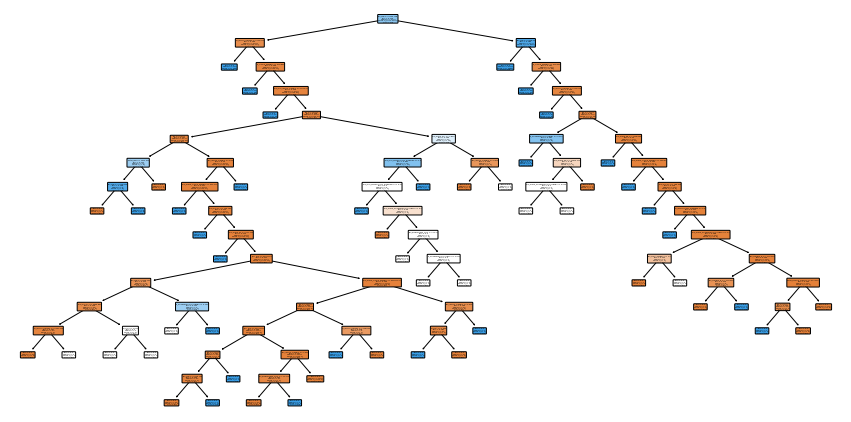

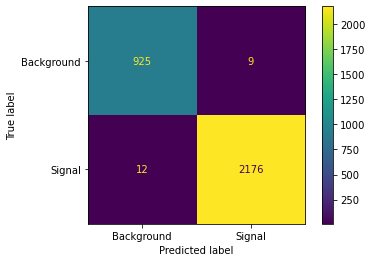

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # splitting data into test and train samples
clf_dt = DecisionTreeClassifier() # creating a Decision Tree
clf_dt = clf_dt.fit(X_train, Y_train) # training it

# Plotting a resulting decision tree
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Plotting a confusion matrix, which will check on the test data false-positive and false-negative identifications
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

<h3>Next section investigates overfitting prevention</h3>

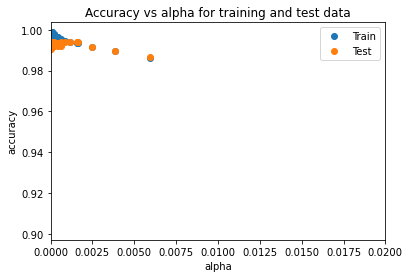

In [117]:
# Decision tree is likely to overfit the test data, so it should be provided with a cost for growing complexity (ccp_alpha)

path = clf_dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # last one should be removed

clf_dts = []

# creating a bunch of decision trees with different ccp_alpha variables
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, Y_train)
    clf_dts.append(clf_dt)
   
# checking train and test scores for those trees of different ccp_alpha
train_scores = [clf_dt.score(X_train, Y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, Y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and test data")
ax.plot(ccp_alphas, train_scores, 'o', label = "Train", drawstyle = "steps-post")
ax.plot(ccp_alphas, test_scores, 'o', label = "Test", drawstyle = "steps-post")
plt.legend()
plt.xlim(0.00, 0.02) # limits are used to find on a graph the best alpha
plt.show()


In [118]:
# alpha that was identified on a plot as being the best one is extracted
alpha = ccp_alphas[(ccp_alphas > 0.005) & (ccp_alphas < 0.0075)]
print(alpha)

[0.0059108]


<AxesSubplot:xlabel='tree'>

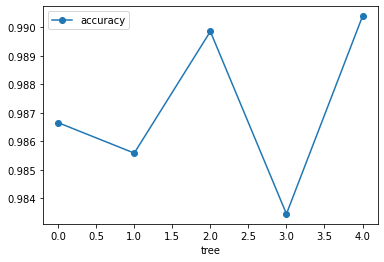

In [119]:
clf_dt = DecisionTreeClassifier(ccp_alpha = alpha)
scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5) # 5 decision trees are done on different subsets of the train data
df = pd.DataFrame(data = {'tree': range(5), 'accuracy': scores})
# Accuracy is checked for different trees
df.plot(x='tree', y='accuracy', marker = 'o')

# Conclusion is that alpha that gives the best accuracy for one data subset, can perform much worse on another
# Therefore, a range of alpha should be checked with different data being used to find which alpha perform on average better
# regardless of the way test data is sumpled

<h3>End of investigation</h3>

<AxesSubplot:xlabel='alpha'>

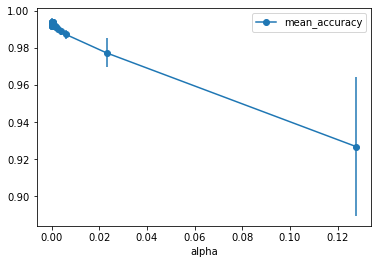

In [120]:
alpha_loop_values = []
# Check different alpha values with cross validation providing errorbars
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, columns = ["alpha", "mean_accuracy", "std"])

alpha_results.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')

<AxesSubplot:xlabel='alpha'>

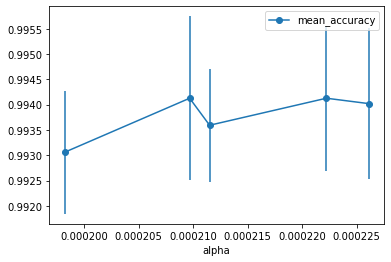

In [127]:
# find the best alpha in terms of absolute accuracy and its error
alpha_results[13:-15].plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')


0.00020967820220356258


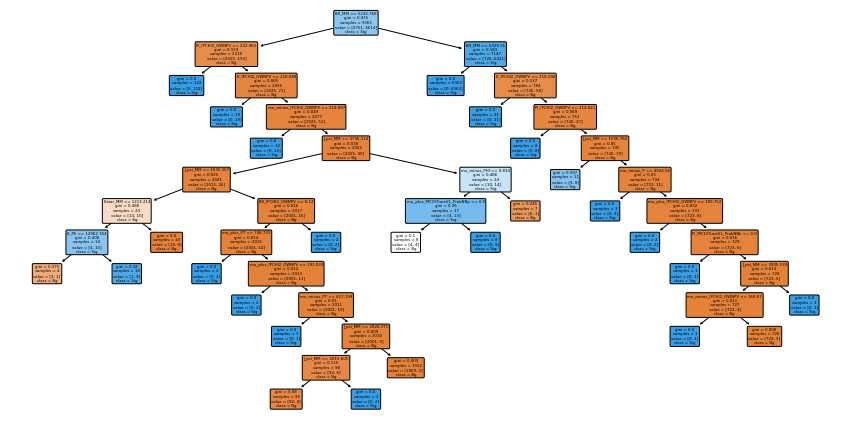

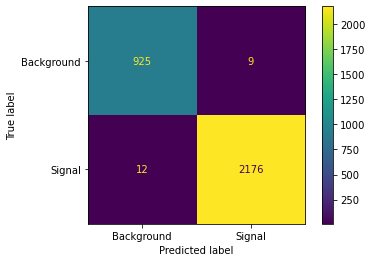

In [129]:
# Extract the best value of alpha
ideal_alpha = ccp_alphas[(ccp_alphas > 0.000205) & (ccp_alphas < 0.000210)]
ideal_alpha = float(ideal_alpha)
print(ideal_alpha)

# Resulting decision tree with the ccp_alpha being used to prevent overfitting
clf_dt = DecisionTreeClassifier(ccp_alpha = ideal_alpha)
clf_dt = clf_dt.fit(X_train, Y_train)

plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Corresponding confusion matrix
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

Total number of events: 44132
Number of events in the mass region 40447
Number of bg (0) and signal (1) events identified (array([0., 1.]), array([    8, 40439], dtype=int64))


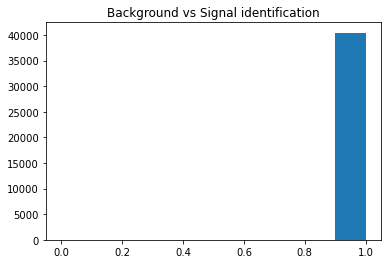

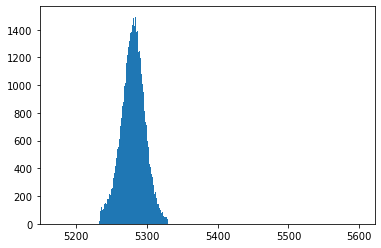

In [130]:
df = pd.read_pickle("total_dataset_filtered.pkl")
df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1)
print("Total number of events:", len(df))
total_data = df[(df["B0_MM"] > min_mass) & (df["B0_MM"] < max_mass)].drop(["year", "polarity", "Unnamed: 0"], axis = 1)
print("Number of events in the mass region", len(total_data))

# Passing data to decision tree
result = clf_dt.predict(total_data)

print("Number of bg (0) and signal (1) events identified", np.unique(result, return_counts = True))
plt.title("Background vs Signal identification")
plt.hist(result)
plt.show()

# Extracting signal data to 'Filtered_data.pkl'
total_data["Result"] = result
filtered = total_data[total_data["Result"] == 1]
filtered.to_pickle("Filtered_data.pkl")

# Histogram of the filtered data
plt.hist(filtered['B0_MM'], range=[5170, 5600], bins=300, zorder=1)
plt.show()